# Feature Selection - Random Forest

**Feature selection using Recursive Feature Elimination**: the idea is to fit the model, then remove the less relevant feature and calculate the average value of some performance metric in CV. Then we remove the second last important feature, fit the model again and calculate the average performance. We keep doing this approach until there are no features left. The set of features that maximize the performance in CV is the set of features we have to work with.

## Libraries and Configurations

Import configuration files

In [25]:
from configparser import ConfigParser

config = ConfigParser()
config.read("../config.ini")

['../config.ini']

Import **data libraries**

In [26]:
import pandas as pd

Import **ML libraries**

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel

Import **other libraries**

In [28]:
from rich.progress import Progress
from rich import traceback

traceback.install()

<bound method InteractiveShell.excepthook of <ipykernel.zmqshell.ZMQInteractiveShell object at 0x105e40dd0>>

In [29]:
import numpy as np
import matplotlib.pyplot as plt

Custom helper scripts

In [30]:
%cd ..
from scripts import plotHelper, encodingHelper
%cd data_exploration_cleaning

/Users/bacci/Library/CloudStorage/SynologyDrive-giovanni/Research 🌱/Repositories/COMPACT/notebooks
/Users/bacci/Library/CloudStorage/SynologyDrive-giovanni/Research 🌱/Repositories/COMPACT/notebooks/data_exploration_cleaning


In [31]:
reports_path = config["DEFAULT"]["reports_path"]

## SUM Encoded Data

In [32]:
# Combined dataframe
df_sum_csv = config["DEFAULT"]["interim_path"] + "encoded_SUM_balanced_df_length.csv"

In [33]:
df_sum = pd.read_csv(df_sum_csv, index_col=0)

In [34]:
df_sum

,Timestamp,MAC Address,Channel,DS Channel,HT Capabilities SUM,Extended Capabilities SUM,Vendor Specific Tags SUM,Supported Rates SUM,Extended Supported Rates SUM,Length,Label,Length NO SSID
0,2023-05-20 13:52:01.864465952,d2:6b:aa:b5:fb:ed,1,1.0,2709,830,-1,479,915,135,iPhone12Pro_C,135
1,2023-05-20 13:52:01.884716034,d2:6b:aa:b5:fb:ed,1,1.0,2709,830,-1,479,915,135,iPhone12Pro_C,135
2,2023-05-20 13:52:01.910542011,d2:6b:aa:b5:fb:ed,6,6.0,2709,830,-1,479,915,135,iPhone12Pro_C,135
3,2023-05-20 13:52:01.930788994,d2:6b:aa:b5:fb:ed,6,6.0,2709,830,-1,479,915,135,iPhone12Pro_C,135
4,2023-05-20 13:52:01.968745947,d2:6b:aa:b5:fb:ed,11,11.0,2709,830,-1,479,915,135,iPhone12Pro_C,135
...,...,...,...,...,...,...,...,...,...,...,...,...
36055,2021-07-07 12:02:57.579541922,da:a1:19:00:17:f9,6,1.0,2663,1032,747,447,915,182,XiaomiRedmiNote7_S,182
36056,2021-07-07 11:32:04.533828019,da:a1:19:1a:cc:8f,6,8.0,2663,1032,747,447,915,198,XiaomiRedmiNote7_S,182
36057,2021-07-07 11:46:50.089955091,da:a1:19:41:c9:b1,11,5.0,2663,1032,747,447,915,143,XiaomiRedmiNote7_S,143
36058,2021-07-07 12:16:31.309731960,da:a1:19:c7:24:b1,1,3.0,2663,1032,747,447,915,182,XiaomiRedmiNote7_S,182


In [35]:
to_drop = ["Timestamp", "MAC Address"]
df_sum = df_sum.drop(to_drop, axis=1)

### Split Dataframe

In [36]:
X = df_sum.drop(columns=["Label"])
y = df_sum["Label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

### Normalize Data

In [37]:
min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

### Random Forest

In [38]:
sel = SelectFromModel(RandomForestClassifier(n_estimators=100))
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier())

In [39]:
selected_feat = X_train.columns[(sel.get_support())]
len(selected_feat)

5

In [40]:
print(selected_feat)

Index(['HT Capabilities SUM', 'Extended Capabilities SUM',
       'Vendor Specific Tags SUM', 'Length', 'Length NO SSID'],
      dtype='object')


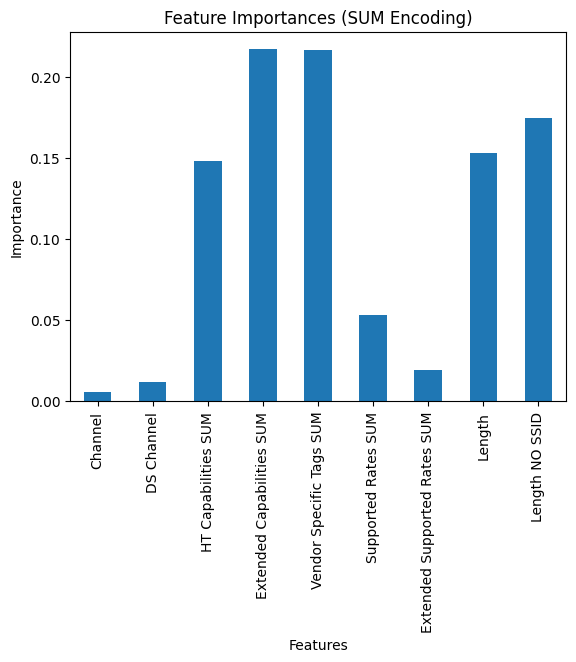

In [41]:
feature_importances = pd.Series(
    sel.estimator_.feature_importances_.ravel(), index=X_train.columns
)
feature_importances.plot(kind="bar")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importances (SUM Encoding)")
plt.show()

Saving feature importance to file

In [42]:
importances_df = pd.DataFrame(
    {"Feature": feature_importances.index, "Importance": feature_importances.values}
)
importances_df.to_csv(
    reports_path + "/CSV/feature_selection/SUM_importances_RF.csv", index=False
)

## Label Encoded Data

In [43]:
# Combined dataframe
df_label_csv = (
    config["DEFAULT"]["interim_path"] + "encoded_LABEL_balanced_df_length.csv"
)

In [44]:
df_label = pd.read_csv(df_label_csv, index_col=0)

In [45]:
to_drop = ["Timestamp", "MAC Address", "SSID"]
df_label = df_label.drop(to_drop, axis=1)

In [46]:
df_label

,Channel,DS Channel,HT Capabilities,Extended Capabilities,Vendor Specific Tags,Supported Rates,Extended Supported Rates,VHT Capabilities,HE Capabilities,Length,Label,Length NO SSID
0,1,1.0,6,17,-1,2,0,-1,62,135,iPhone12Pro_C,135
1,1,1.0,6,17,-1,2,0,-1,62,135,iPhone12Pro_C,135
2,6,6.0,6,17,-1,2,0,-1,62,135,iPhone12Pro_C,135
3,6,6.0,6,17,-1,2,0,-1,62,135,iPhone12Pro_C,135
4,11,11.0,6,17,-1,2,0,-1,62,135,iPhone12Pro_C,135
...,...,...,...,...,...,...,...,...,...,...,...,...
36055,6,1.0,8,7,25,0,0,0,13,182,XiaomiRedmiNote7_S,182
36056,6,8.0,8,7,25,0,0,0,14,198,XiaomiRedmiNote7_S,182
36057,11,5.0,8,7,25,0,0,0,32,143,XiaomiRedmiNote7_S,143
36058,1,3.0,8,7,25,0,0,0,14,182,XiaomiRedmiNote7_S,182


### Split Dataframe

In [47]:
W = df_label.drop(columns=["Label"])
k = df_label["Label"]

W_train, W_test, k_train, k_test = train_test_split(
    W, k, test_size=0.4, random_state=42, stratify=y
)

### Normalize Data

In [48]:
min_max_scaler = MinMaxScaler()
W_train = min_max_scaler.fit_transform(W_train)
W_test = min_max_scaler.transform(W_test)

W_train = pd.DataFrame(W_train, columns=W.columns)
W_test = pd.DataFrame(W_test, columns=W.columns)

### Random Forest

In [49]:
sel_label = SelectFromModel(RandomForestClassifier(n_estimators=100))
sel_label.fit(W_train, k_train)

SelectFromModel(estimator=RandomForestClassifier())

In [50]:
selected_feat_label = W_train.columns[(sel_label.get_support())]
len(selected_feat_label)

5

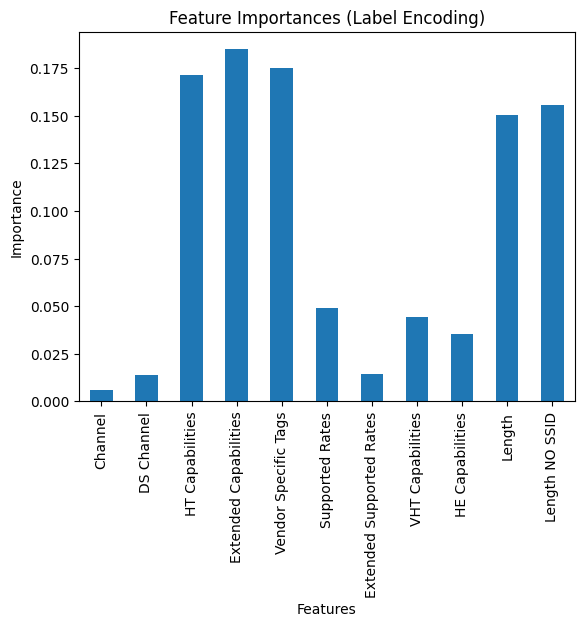

In [51]:
feature_importances_label = pd.Series(
    sel_label.estimator_.feature_importances_.ravel(), index=W_train.columns
)
feature_importances_label.plot(kind="bar")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importances (Label Encoding)")
plt.show()

Saving feature importance to file

In [52]:
importances_label_df = pd.DataFrame(
    {
        "Feature": feature_importances_label.index,
        "Importance": feature_importances_label.values,
    }
)
importances_label_df.to_csv(
    reports_path + "/CSV/feature_selection/LABEL_importances_RF.csv", index=False
)